# Task A

### 1.
I'm training xgboost for speed dating dataset. Model performance is very high:
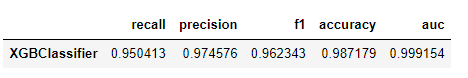

### 2. 
I've choosen two quite different observation but belonging to the same class:
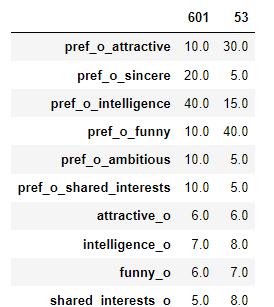
predictions are:
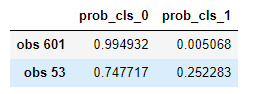

### 3.
Python: dalex and shap

I have choosen two observation randomly just to see differences between both packages (this is not for 4. subtask). 
Dalex and Shap respectively - orders of variables slightly changes:
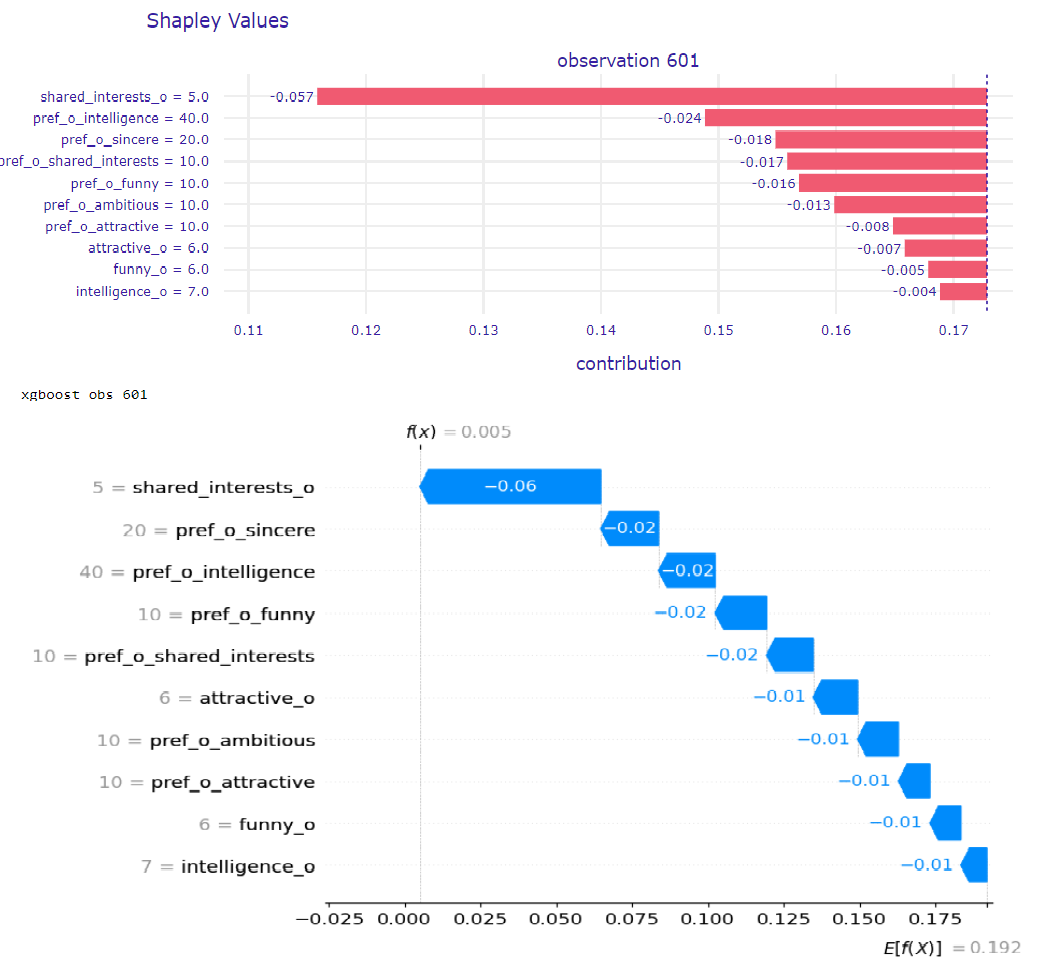

same for second observation - but here also most influentian variable changes - reason is that dalex estimates Shapley values (in Dalex `predict_part` returns `#numer of variables * 25` rows which are sort of estimates and are then aggregated):

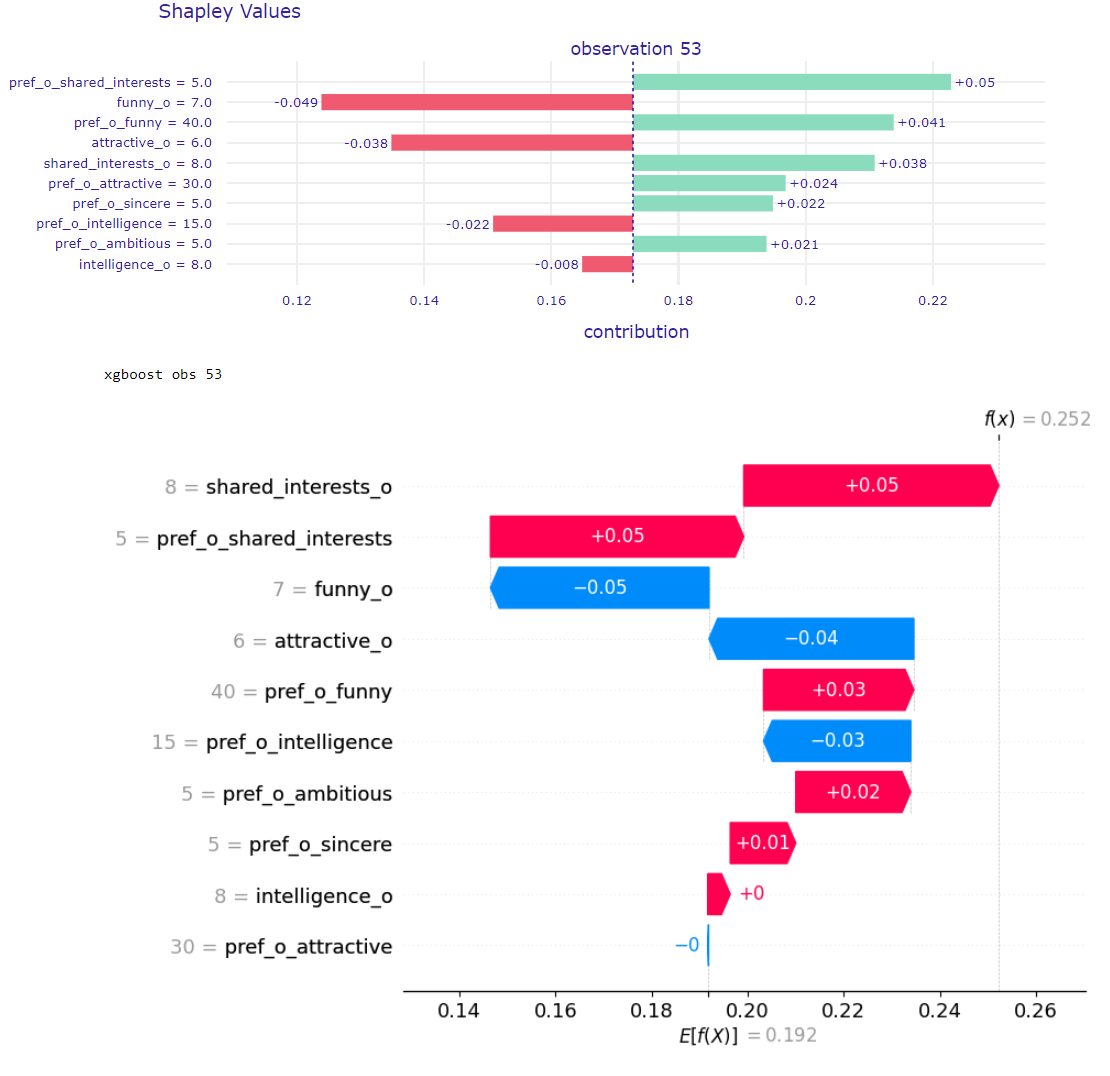

### 4.
Number of unique pairs of observations which differs at two top position of variables ordered by absolute Shapley value is 24081 for SHAP package and 25827 for DALEX. Which is reasonable as DALEX aproximates Shape values which injects additional randomnes into variables ordering. Calculaction for DALEX have been obtained by agregating results from `predict_parts` method.



First pair of observation which differs by top two variables by abs Shapley value - results from Shap package:
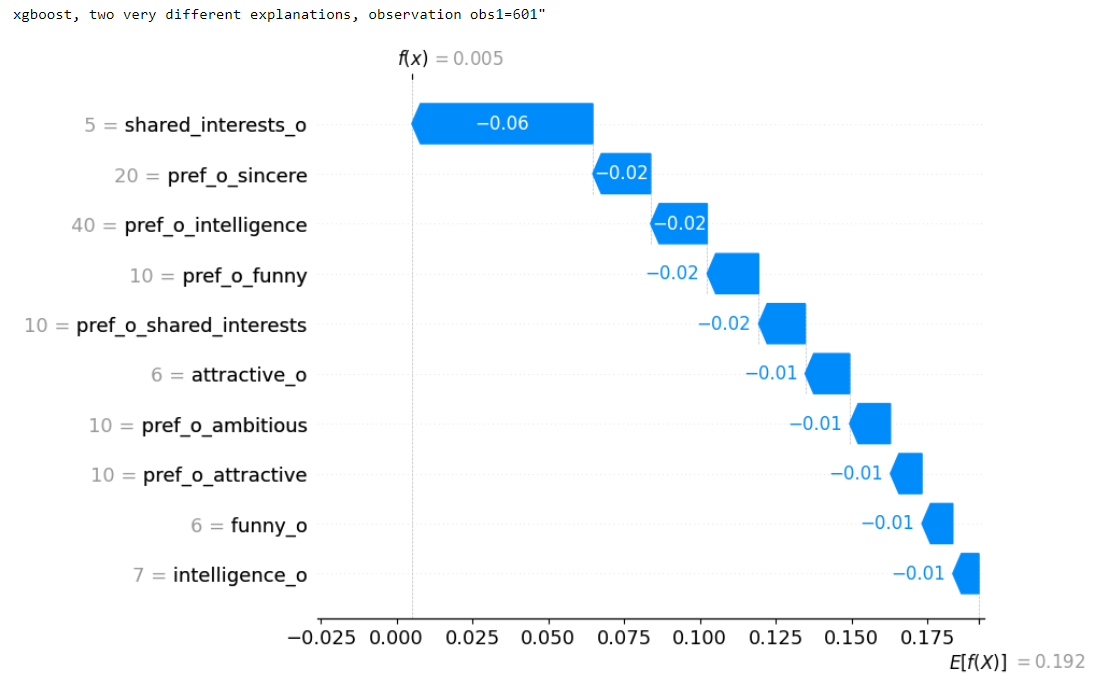
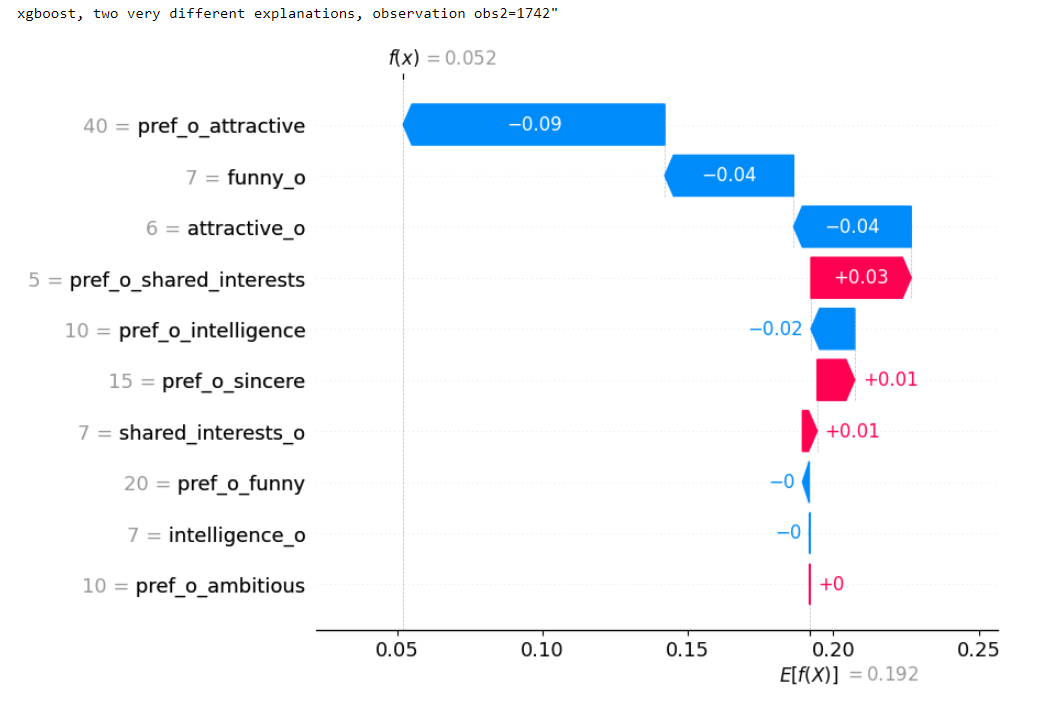

Same pair of observations plot with Dalex - we can see that two first variables from obs 601 are again much below two top places in obs 1742, unfortunately top places between Dalex and Shap changes for each observation:
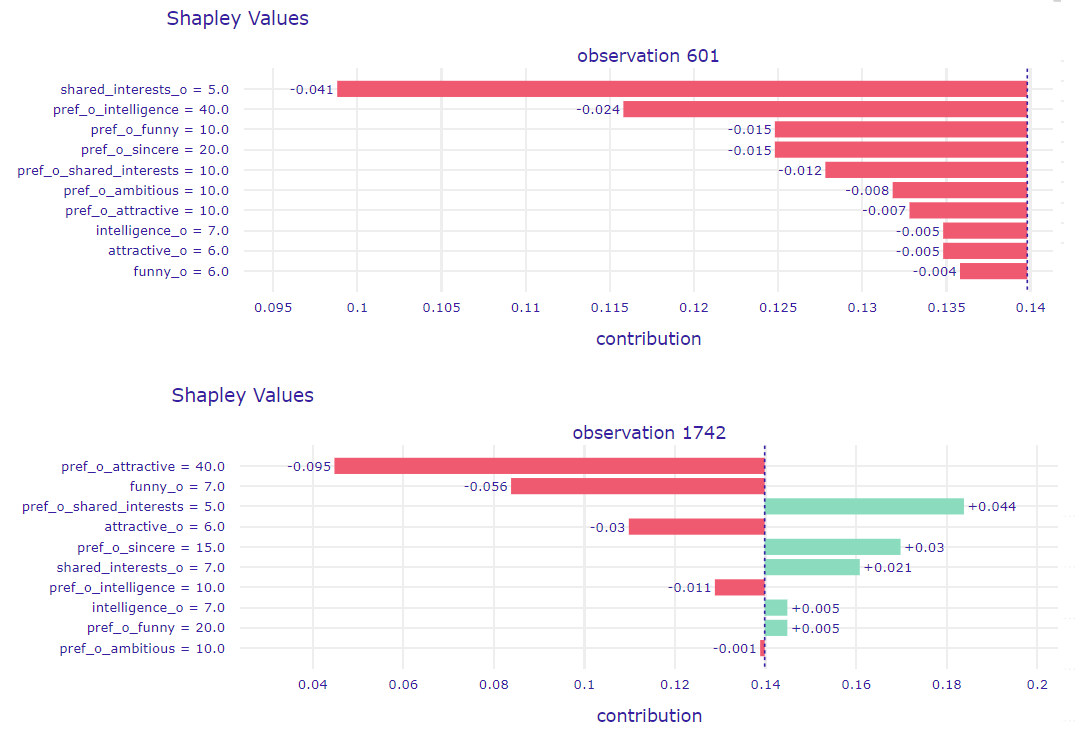

# 5.
I've iterated over are possible pairs of variables and found that this two observations are most different from each other in terms of abs difference of Shapley for `shared_interests_o` variable (Shap package):
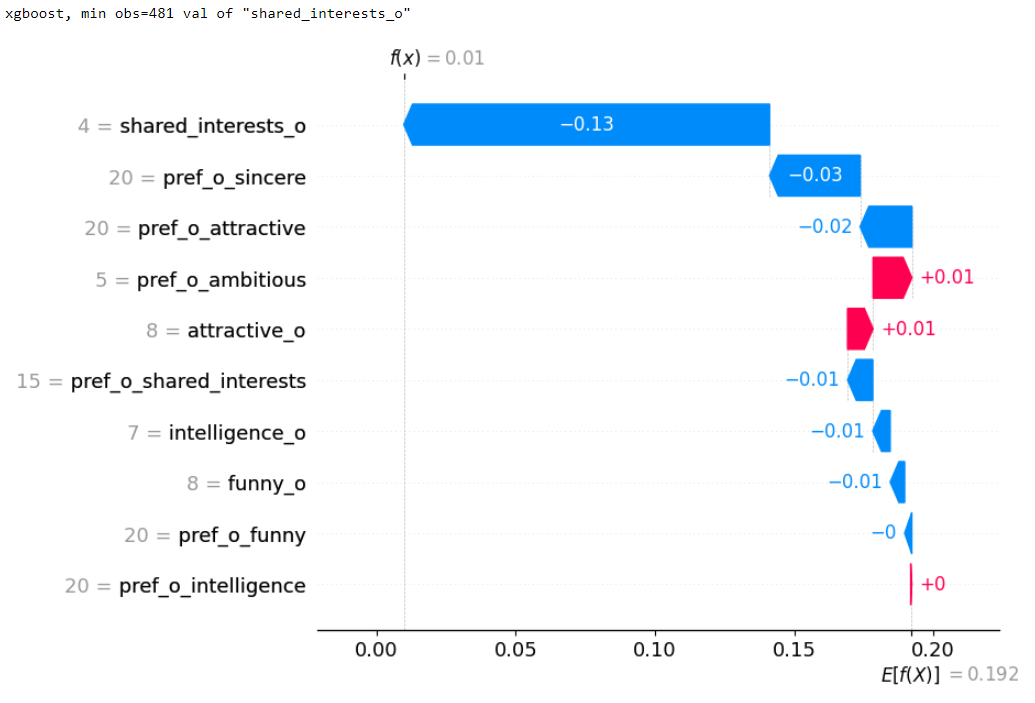
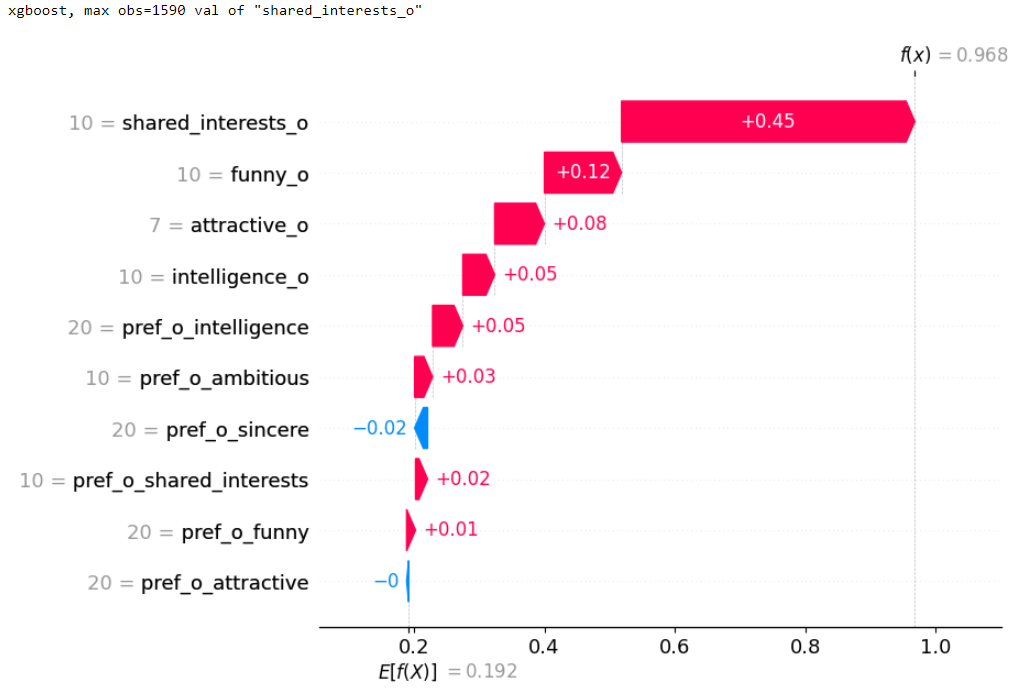

The same task solved with Dalex. Shapley values for variable `shared_interests_o` for all obs in test dataset have been calculated. The same pair of variables have been found - so difference between Shapley values between packages are not so huge.
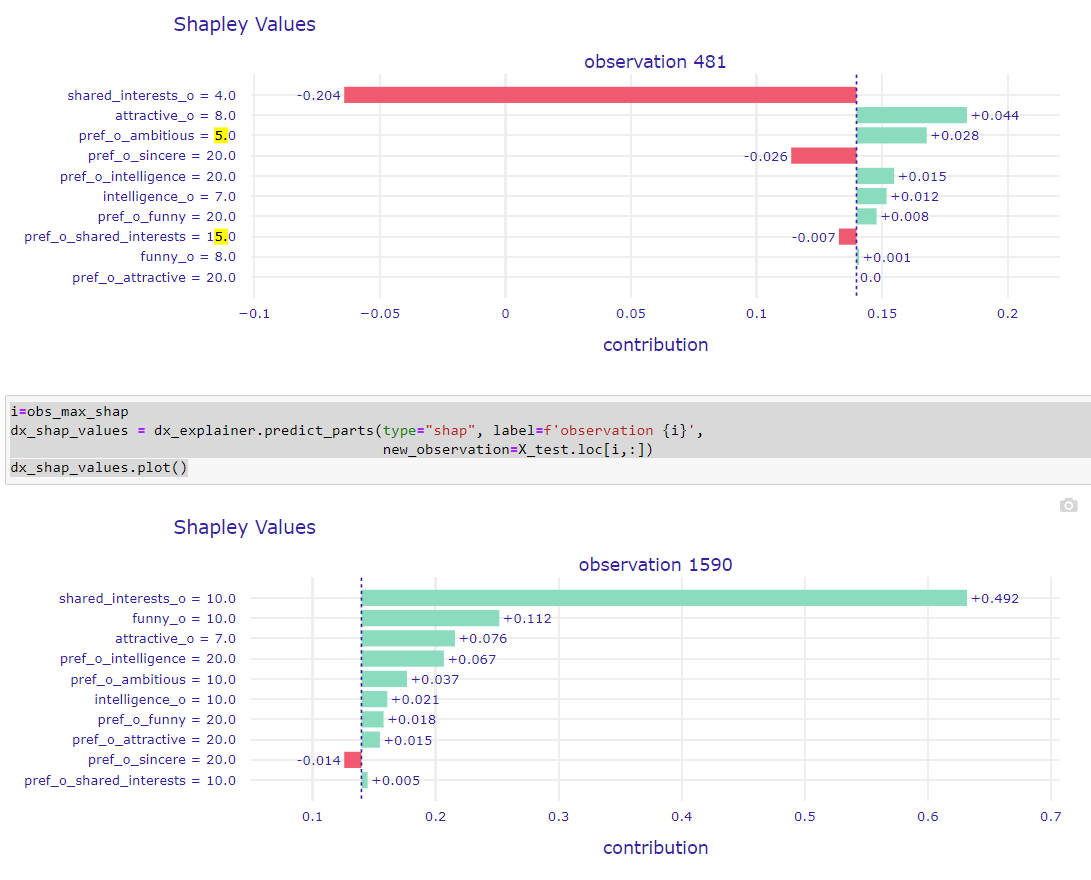

# 6.
Done above.

# 7.
I choose logistic regression model. Data have to been scaled in adventage to assure convergence which is additional complication in pipeline, as preprocessing.scalar.preprocessing return numpy array, and we need pandas' df for xai methods (variable names).

I've searched for two variables in test dataset which Shapley values profiles differs most between xgboost and ogistic regression, obtained difference is huge because different classes have been predicted by each model:

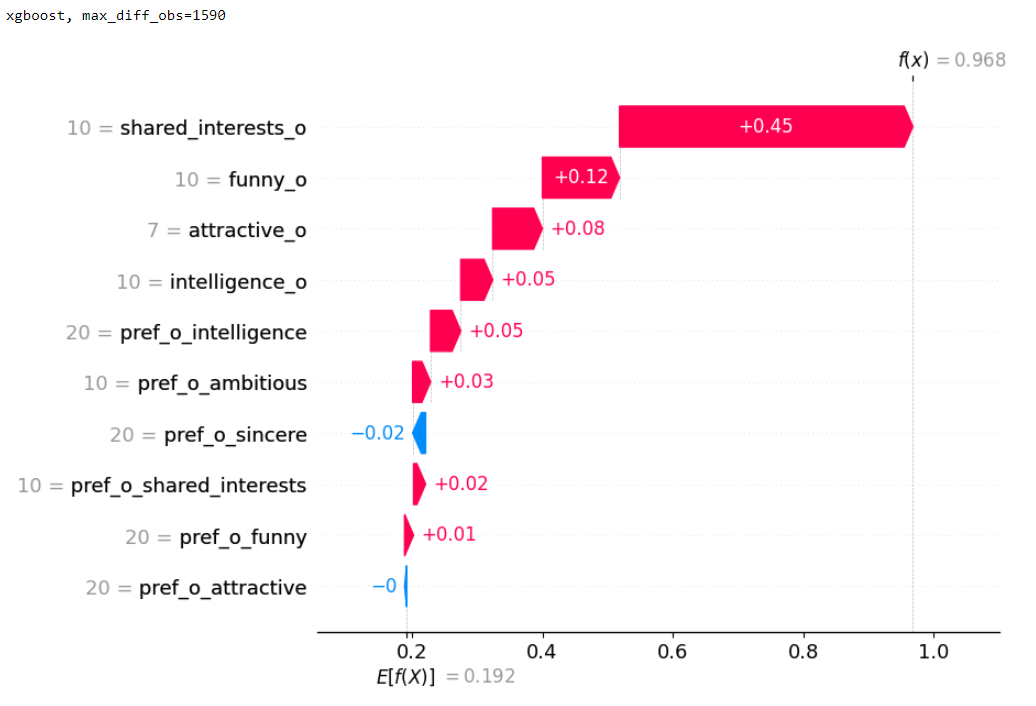

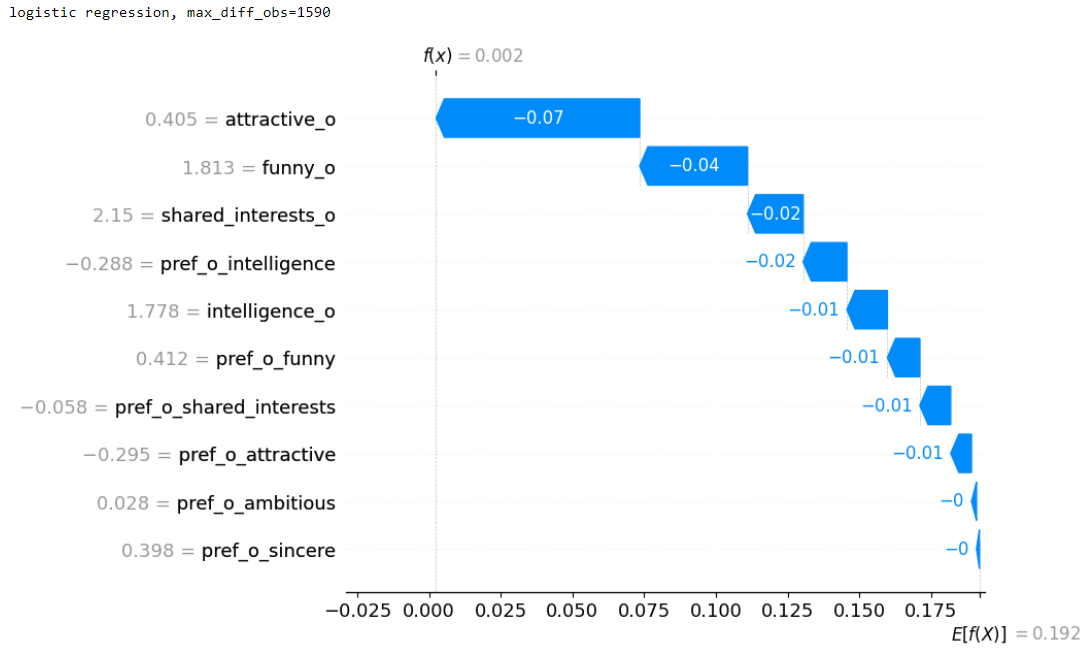

# Task B

We have six permutations:

    (A, B, C): Contribution of A is v(A) - v(empty set) = 20 - 0 = 20
    (A, C, B): Contribution of A is v(A) - v(empty set) = 20 - 0 = 20
    (B, A, C): Contribution of A is v(A, B) - v(B) = 60 - 20 = 40
    (C, A, B): Contribution of A is v(A, C) - v(C) = 70 - 60 = 10
    (B, C, A): Contribution of A is v(A, B, C) - v(B, C) = 100 - 70 = 30
    (C, B, A): Contribution of A is v(A, B, C) - v(B, C) = 100 - 70 = 30

The average contribution of A during building the coalition is (20 + 20 + 40 + 10 + 30 + 30) / 6 = 25, which is the Shapley value of player (variable) A.

### Additionaly Ive compared three tree based models - shap profiles are very similar, ordering of variables is stable with minor swaps between consecutive places:

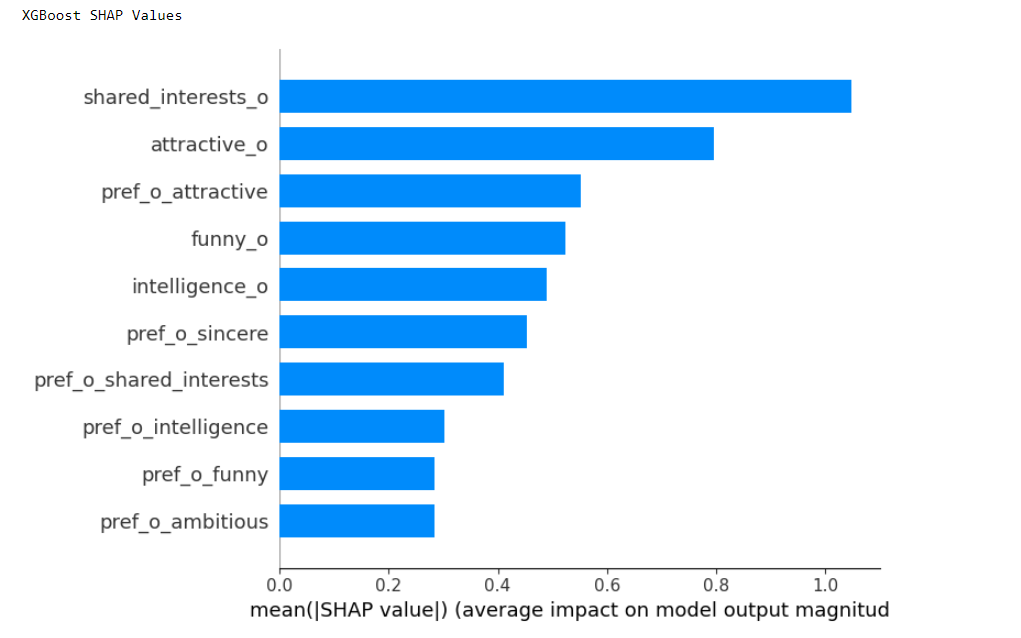
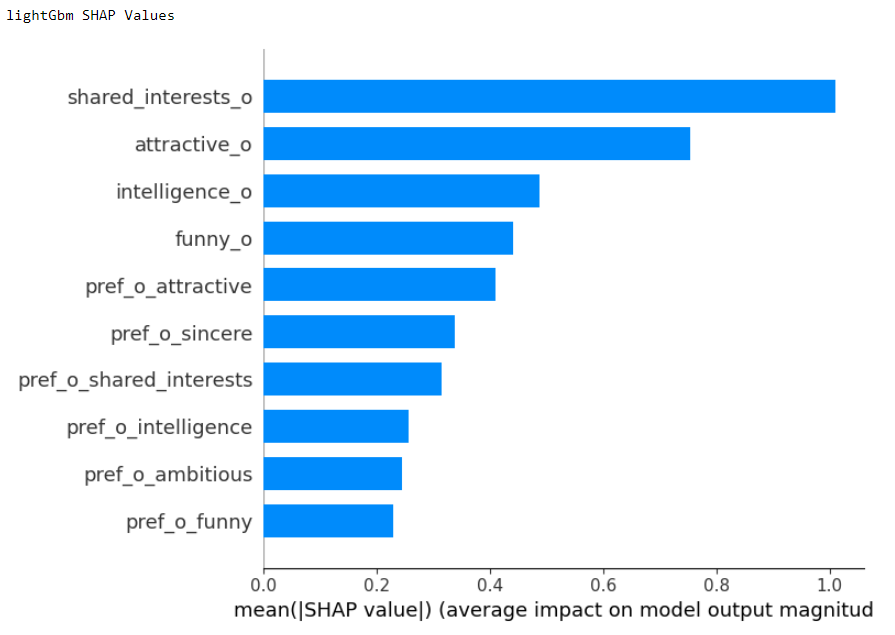
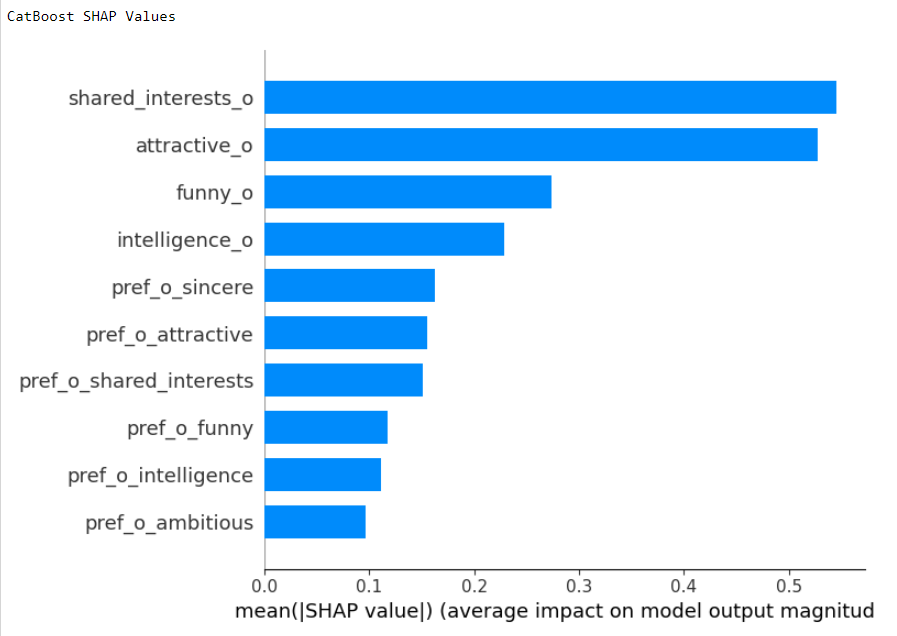

# Appendix

In [1]:
SEED = 42

In [2]:
import numpy as np
import pandas as pd
from os.path import exists

repo_url = "https://raw.githubusercontent.com/adrianstando/imbalanced-benchmarking-set/main/datasets/"
dataset = "SpeedDating.csv" # ♥


if exists(dataset):
    # print("File already exists, loading file")
    df = pd.read_csv(dataset, index_col=0)
else:
    try:
        df = pd.read_csv(repo_url + dataset, index_col=0)
        df.to_csv(dataset)
    except:
        print("somthing is not yes")

In [3]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from  sklearn.model_selection import train_test_split

y = df['TARGET']
X = df.drop(columns=['TARGET'])

X_train, X_test, y_train, y_test = train_test_split(X.iloc[:,:10], y, test_size=0.33, random_state=SEED)

In [4]:
# 1. Train a tree-based ensemble model on the selected dataset; it can be one of random forest,
# GBM, CatBoost, XGBoost, LightGBM (various types) etc.

In [5]:
import xgboost as xgb

print(xgb.__version__)

xgb_clf = xgb.XGBClassifier(
    objective='binary:logistic',
    max_depth=10,
    learning_rate=0.1,
    n_estimators=100,
    # early_stopping_rounds=3 # can't use directly in CV setting with train-test split only (val dataset would be needed)
    # scale_pos_weight=df.TARGET.mean()  # using 'scale_pos_weight' this way would be data leakage
)

xgb_clf.fit(X_train, y_train)

y_pred = xgb_clf.predict(X_test)

print(f"{accuracy_score(y_test, y_pred)=:.5f}\n{1-np.mean(y_test)=:.5f}")
confusion_matrix(y_test, y_pred)

2.0.1
accuracy_score(y_test, y_pred)=0.80058
1-np.mean(y_test)=0.81214


array([[264,  17],
       [ 52,  13]], dtype=int64)

In [6]:
X_test.index

Int64Index([ 601, 1742, 1520, 1740,   53,  751,  356,  722,  194, 1198,
            ...
            1137,  412, 1453,  374, 1735,  723,  862,  396, 1613, 1351],
           dtype='int64', length=346)

In [7]:
# 2. Select two observations from the dataset and calculate the model's prediction.
obs = [601, 53]
xgb_clf.predict(X_test.loc[obs, :])

array([0, 0])

In [209]:
pred = xgb_clf.predict_proba(X_test.loc[obs, :])
pd.DataFrame(pred, columns=["prob_cls_0", "prob_cls_1"], index=["obs 601", "obs 53"])

prob_cls_0  prob_cls_1
obs 601    0.994932    0.005068
obs 53     0.747717    0.252283

In [206]:
X_test.loc[obs,:].T

601   53 
pref_o_attractive        10.0  30.0
pref_o_sincere           20.0   5.0
pref_o_intelligence      40.0  15.0
pref_o_funny             10.0  40.0
pref_o_ambitious         10.0   5.0
pref_o_shared_interests  10.0   5.0
attractive_o              6.0   6.0
intelligence_o            7.0   8.0
funny_o                   6.0   7.0
shared_interests_o        5.0   8.0

### 3. Next, for the same observations, calculate the decomposition of predictions,
### so-called variable attributions, using SHAP from two packages of choice,
### e.g. for Python: dalex and shap, for R: DALEX and iml.

In [11]:
try:
  import shap
except:
  !pip install -q shap
  import shap

try:
  import dalex as dx
except:
  !pip install -q dalex
  import dalex as dx

from tqdm.notebook import tqdm

dx_explainer = dx.Explainer(xgb_clf, X_train, y_train)
dx_explainer.model_performance()

C:\Users\laptop\anaconda3\envs\pytorch_cpu\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Preparation of a new explainer is initiated

  -> data              : 702 rows 10 cols
  -> target variable   : Parameter 'y' was a pandas.Series. Converted to a numpy.ndarray.
  -> target variable   : 702 values
  -> model_class       : xgboost.sklearn.XGBClassifier (default)
  -> label             : Not specified, model's class short name will be used. (default)
  -> predict function  : <function yhat_proba_default at 0x0000013495DC9D80> will be used (default)
  -> predict function  : Accepts pandas.DataFrame and numpy.ndarray.
  -> predicted values  : min = 0.000694, mean = 0.173, max = 0.983
  -> model type        : classification will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -0.583, mean = -0.000481, max = 0.698
  -> model_info        : package xgboost

A new explainer has been created!


In [13]:
i = obs[0]
dx_shap_values = dx_explainer.predict_parts(type="shap", label=f'observation {i}',
                                            new_observation=X_test.loc[i,:])
dx_shap_values.plot()

C:\Users\laptop\anaconda3\envs\pytorch_cpu\lib\site-packages\xgboost\core.py:160: UserWarning:

[16:19:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.



xgboost obs 601


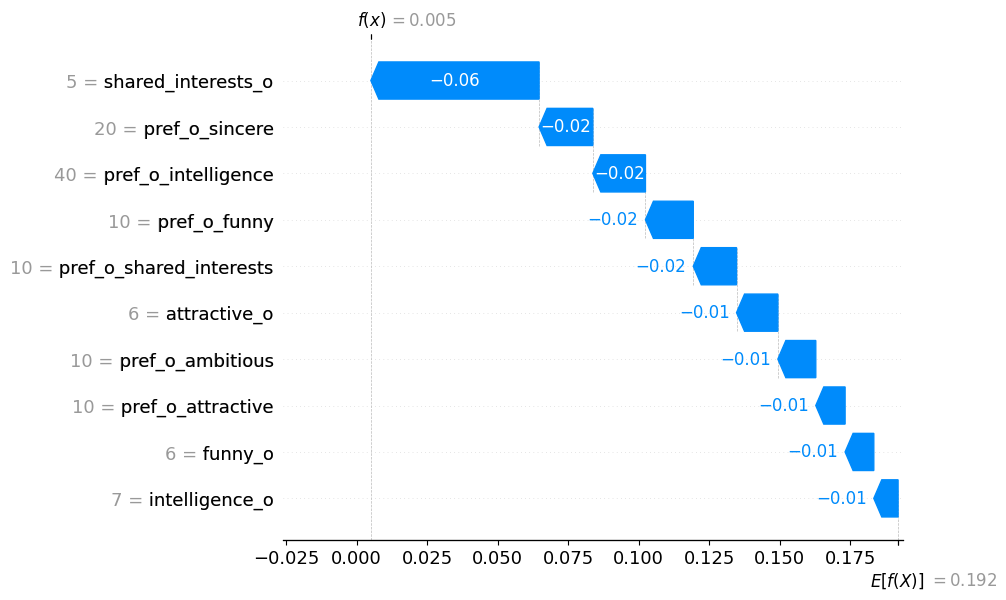

In [210]:
shap_explainer = shap.TreeExplainer(xgb_clf, data=X_train, model_output="probability")
shap_values = shap_explainer(X_test.loc[[obs[0]],:]) # shap_values # = shap_values[:, :, 1]

print('xgboost obs 601')
shap.waterfall_plot(shap_values[0])

In [15]:
i = obs[1]
dx_shap_values = dx_explainer.predict_parts(type="shap", label=f'observation {i}',
                                            new_observation=X_test.loc[i,:])
dx_shap_values.plot()

C:\Users\laptop\anaconda3\envs\pytorch_cpu\lib\site-packages\xgboost\core.py:160: UserWarning:

[16:24:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.



xgboost obs 53


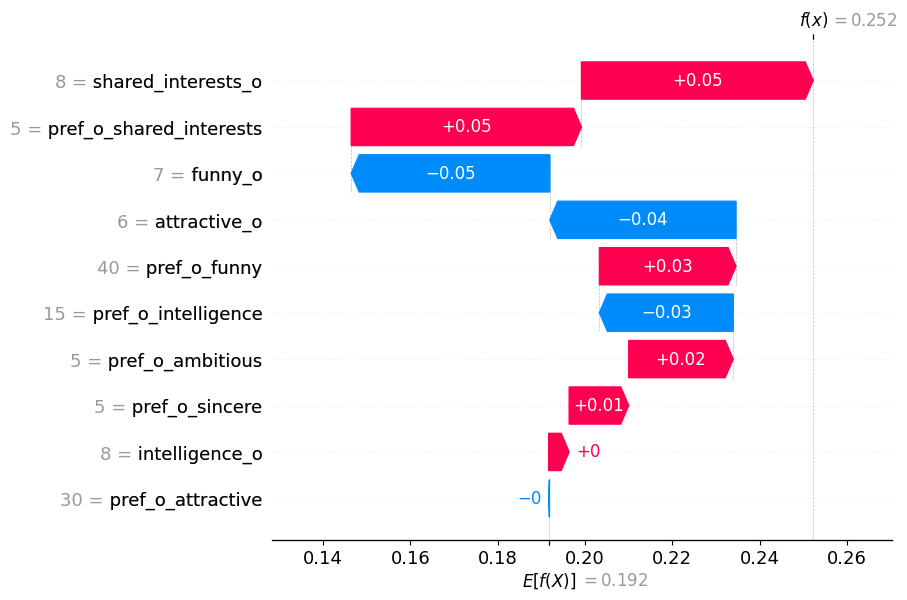

In [211]:
shap_explainer = shap.TreeExplainer(xgb_clf, data=X_train, model_output="probability")
shap_values = shap_explainer(X_test.loc[[obs[1]],:]) # shap_values # = shap_values[:, :, 1]

print('xgboost obs 53')
shap.waterfall_plot(shap_values[0])

In [17]:
shap_values.values

array([[-0.00017708,  0.01364147, -0.0306421 ,  0.03127935,  0.02392793,
         0.05272474, -0.04262999,  0.00469036, -0.04548523,  0.05307745]])

### 4. Find any two observations in the dataset, such that they have different variables of the highest importance,
### e.g. age and gender have the highest (absolute) attribution for observation A,
### but race and class are more important for observation B.

In [175]:
# for 'shap' package
explainer = shap.Explainer(xgb_clf)

shap_values = explainer.shap_values(X_test)
shap_df = pd.DataFrame(shap_values, columns=X_test.columns, index=X_test.index)
shap_df_ = shap_df.copy()

C:\Users\laptop\anaconda3\envs\pytorch_cpu\lib\site-packages\xgboost\core.py:160: UserWarning:

[15:48:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.



In [19]:
shap_df['second_max_shap_feature'] = shap_df.abs().apply(lambda row: row.sort_values(ascending=False).index[1], axis=1)
shap_df['max_shap_feature'] = shap_df.iloc[:,:-1].abs().idxmax(axis=1)
shap_df.iloc[:,-5:]

intelligence_o   funny_o  shared_interests_o second_max_shap_feature  \
601        -0.141222 -0.123939           -1.075860          pref_o_sincere   
1742       -0.007065 -0.802696            0.349125                 funny_o   
1520       -0.930387 -0.052787            0.120107          pref_o_sincere   
1740       -0.237089 -0.357586           -0.923979      shared_interests_o   
53         -0.039275 -0.565738            0.558839      shared_interests_o   
...              ...       ...                 ...                     ...   
723        -0.615311 -0.309743           -1.147835      shared_interests_o   
862         0.526608 -0.270879           -0.592681      shared_interests_o   
396        -0.130899 -0.149692           -0.250160        pref_o_ambitious   
1613        0.002721  1.065739           -1.416684            attractive_o   
1351       -0.747990 -0.334942            0.477542            attractive_o   

        max_shap_feature  
601   shared_interests_o  
1742   pref_o_attractive  
1520      intelligence_o  
1740        attractive_o  
53               funny_o  
...                  ...  
723         attractive_o  
862         attractive_o  
396    pref_o_attractive  
1613  shared_interests_o  
1351      intelligence_o  

[346 rows x 5 columns]

In [20]:
# O(n^2) operations
obs_different_max_shaps = []
for i in range(len(shap_df)):
    for j in range(i+1, len(shap_df)):
        features_i = set([shap_df.iloc[i]['max_shap_feature'], shap_df.iloc[i]['second_max_shap_feature']])
        features_j = set([shap_df.iloc[j]['max_shap_feature'], shap_df.iloc[j]['second_max_shap_feature']])
        if set.isdisjoint(features_i, features_j):
            obs_different_max_shaps.append((i, j))

In [21]:
f"for SHAP number of different pairs of obseration with two different variables with max abs shap value is {len(obs_different_max_shaps)}"

'for SHAP number of different pairs of obseration with two different variables with max abs shap value is 24081'

xgboost, two very different explanations, observation obs1=601"


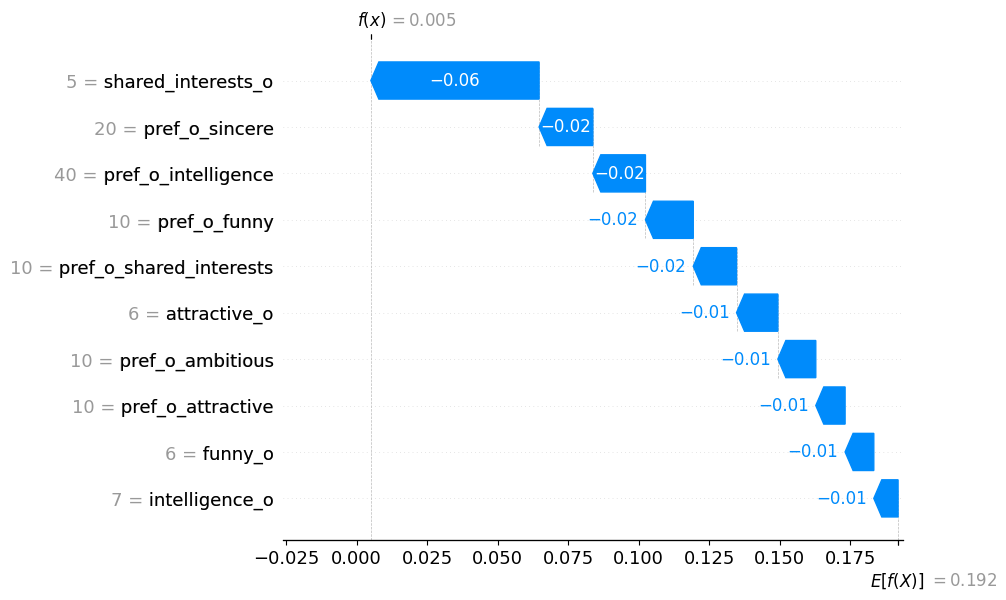

In [113]:
obs1, obs2 = obs_different_max_shaps[0]
obs1 = X_test.index[obs1]
obs2 = X_test.index[obs2]

shap_values = shap_explainer(X_test.loc[[obs1],:])

print(f'xgboost, two very different explanations, observation {obs1=}"')
shap.waterfall_plot(shap_values[0])

xgboost, two very different explanations, observation obs2=1742"


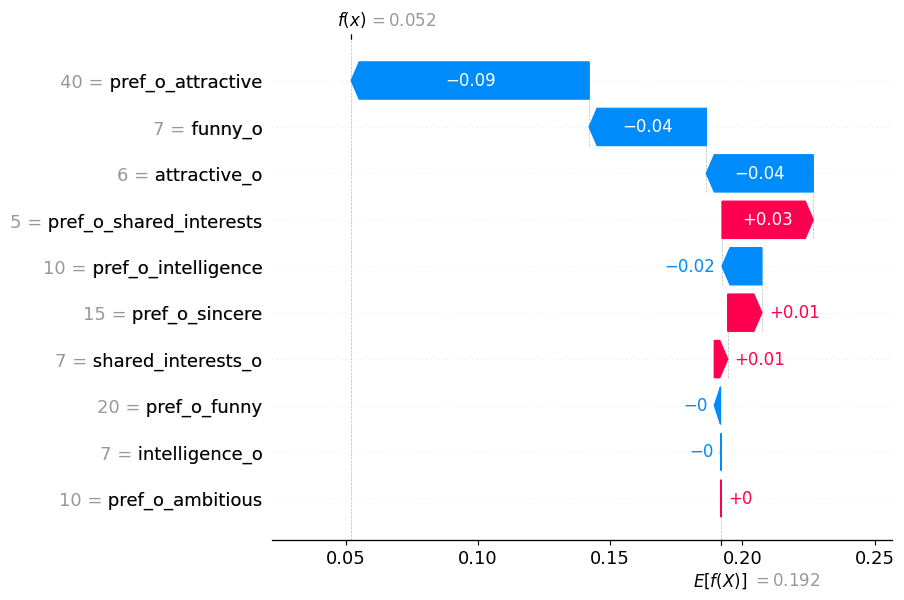

In [114]:
shap_values = shap_explainer(X_test.loc[[obs2],:])

print(f'xgboost, two very different explanations, observation {obs2=}"')
shap.waterfall_plot(shap_values[0])

### 5. (If possible) Select one variable X and find two observations in the dataset such that for one observation,
### X has a positive attribution, and for the other observation, X has a negative attribution.

In [28]:
X_test.columns

Index(['pref_o_attractive', 'pref_o_sincere', 'pref_o_intelligence',
       'pref_o_funny', 'pref_o_ambitious', 'pref_o_shared_interests',
       'attractive_o', 'intelligence_o', 'funny_o', 'shared_interests_o'],
      dtype='object')

In [30]:
# lets choose to most distinct such observation over 'shared_interests_o' variable
obs_min_shap = shap_df['shared_interests_o'].idxmin()
obs_max_shap = shap_df['shared_interests_o'].idxmax()

xgboost, min obs=481 val of "shared_interests_o"


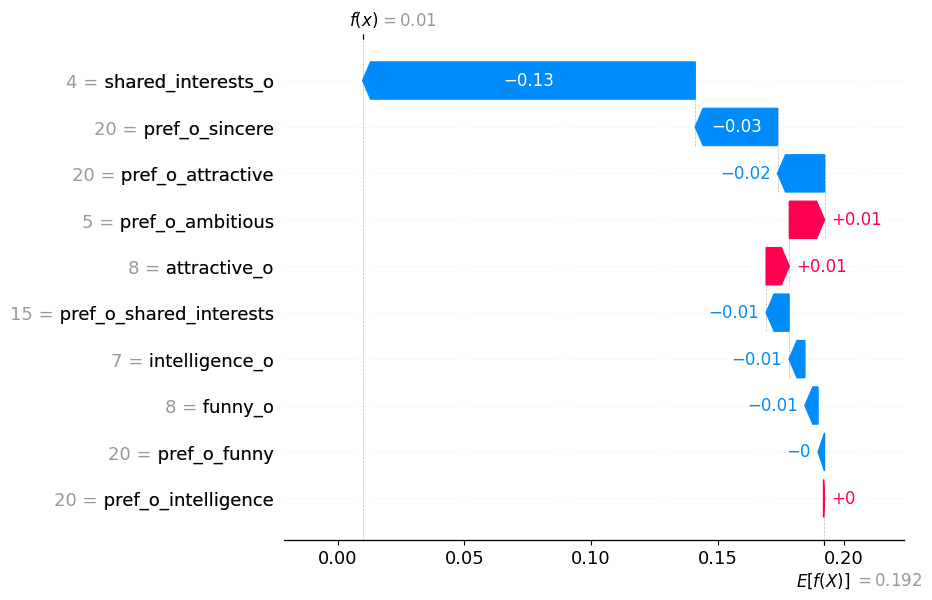

In [31]:
shap_values = shap_explainer(X_test.loc[[obs_min_shap],:]) # shap_values # = shap_values[:, :, 1]

print(f'xgboost, min obs={obs_min_shap} val of "shared_interests_o"')
shap.waterfall_plot(shap_values[0])

xgboost, max obs=1590 val of "shared_interests_o"


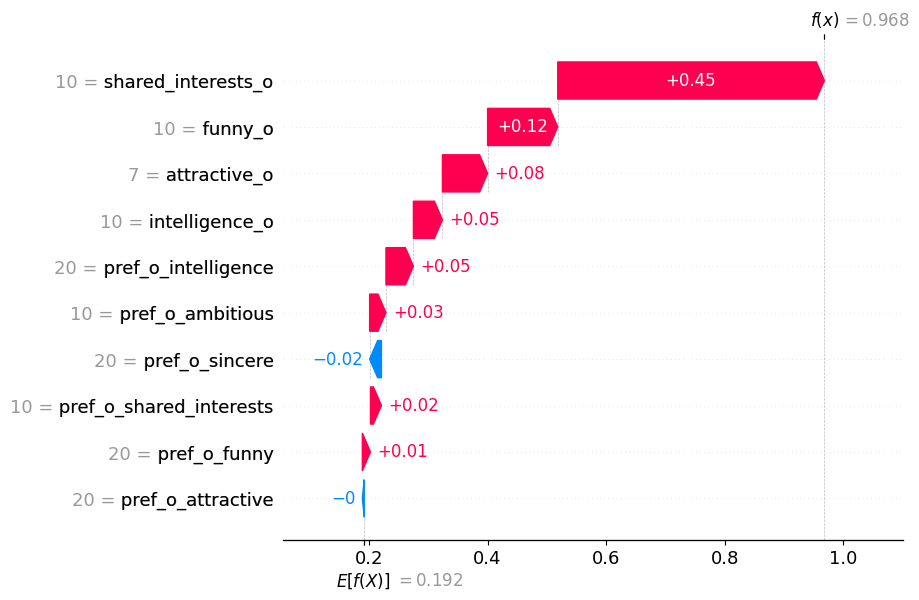

In [32]:
shap_values = shap_explainer(X_test.loc[[obs_max_shap],:]) # shap_values # = shap_values[:, :, 1]

print(f'xgboost, max obs={obs_max_shap} val of "shared_interests_o"')
shap.waterfall_plot(shap_values[0])

In [33]:
dx_explainer = dx.Explainer(xgb_clf, X_train, y_train)

dx_explainer.predict(X_test).shape

Preparation of a new explainer is initiated

  -> data              : 702 rows 10 cols
  -> target variable   : Parameter 'y' was a pandas.Series. Converted to a numpy.ndarray.
  -> target variable   : 702 values
  -> model_class       : xgboost.sklearn.XGBClassifier (default)
  -> label             : Not specified, model's class short name will be used. (default)
  -> predict function  : <function yhat_proba_default at 0x0000013495DC9D80> will be used (default)
  -> predict function  : Accepts pandas.DataFrame and numpy.ndarray.
  -> predicted values  : min = 0.000694, mean = 0.173, max = 0.983
  -> model type        : classification will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -0.583, mean = -0.000481, max = 0.698
  -> model_info        : package xgboost

A new explainer has been created!


(346,)

In [60]:
# 6. (How) Do the results differ across the two packages selected in point (3) ?

In [102]:
#O(n^2)
shap_values_list = []

# Iteracja po wierszach DataFrame X_test i obliczanie wartości SHAP dla każdej obserwacji
# Trzeba agregować 
i=0
for index, row in X_test.iterrows():
    shap_values_instance = dx_explainer.predict_parts(new_observation=row.to_frame().T, type='shap')
    x = shap_values_instance.result[["variable_name", "contribution"]]
    x.set_index("variable_name", inplace=True)
    x = x.groupby("variable_name").apply("mean").T
    x.rename({"contribution":index}, inplace=True)
    shap_values_list.append(x)
    if i%10==0:
        print(i)
    i+=1

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340


In [116]:
shap_df_dx = pd.concat(shap_values_list)
shap_df_dx

variable_name  attractive_o   funny_o  intelligence_o  pref_o_ambitious  \
601               -0.003394 -0.008352       -0.001883         -0.009350   
1742              -0.035736 -0.064267        0.002239         -0.000633   
1520              -0.021804  0.000661       -0.062303          0.003653   
1740              -0.054441 -0.019431       -0.010993          0.015343   
53                -0.025484 -0.049754       -0.003151          0.021081   
...                     ...       ...             ...               ...   
723               -0.049047 -0.017788       -0.017671         -0.004005   
862               -0.087866 -0.030224        0.038842          0.018986   
396               -0.002033 -0.003016       -0.005027         -0.023747   
1613              -0.073227  0.030035        0.005741          0.016645   
1351              -0.041038 -0.032180       -0.051698          0.002123   

variable_name  pref_o_attractive  pref_o_funny  pref_o_intelligence  \
601                     0.000356     -0.012039            -0.015764   
1742                   -0.078059      0.006337            -0.013685   
1520                    0.001017     -0.020271            -0.019580   
1740                    0.002034     -0.007081            -0.038788   
53                      0.032031      0.046751            -0.020398   
...                          ...           ...                  ...   
723                    -0.019186      0.001106             0.004726   
862                     0.016336     -0.000694             0.013232   
396                    -0.059345      0.020251            -0.002361   
1613                    0.027164     -0.000571             0.014264   
1351                    0.033585      0.008090             0.009405   

variable_name  pref_o_shared_interests  pref_o_sincere  shared_interests_o  
601                          -0.010422       -0.012942           -0.060948  
1742                          0.047075        0.031166            0.017835  
1520                          0.016112        0.026275           -0.013184  
1740                          0.013666       -0.000076           -0.032205  
53                            0.050557        0.027671            0.033174  
...                                ...             ...                 ...  
723                           0.004518        0.009570           -0.050375  
862                          -0.012913        0.020614           -0.039265  
396                          -0.001836        0.018678           -0.032757  
1613                          0.018186        0.020867           -0.114425  
1351                         -0.023335       -0.021395            0.017666  

[346 rows x 10 columns]

In [118]:
shap_df_dx_ = shap_df_dx.copy()

In [119]:
shap_df_dx['second_max_shap_feature'] = shap_df_dx.abs().apply(lambda row: row.sort_values(ascending=False).index[1], axis=1)
shap_df_dx['max_shap_feature'] = shap_df_dx.iloc[:,:-1].abs().idxmax(axis=1)
shap_df_dx.iloc[:,-5:]

obs_different_max_shaps = []
for i in range(len(shap_df_dx)):
    for j in range(i+1, len(shap_df_dx)):
        features_i = set([shap_df_dx.iloc[i]['max_shap_feature'], shap_df_dx.iloc[i]['second_max_shap_feature']])
        features_j = set([shap_df_dx.iloc[j]['max_shap_feature'], shap_df_dx.iloc[j]['second_max_shap_feature']])
        if set.isdisjoint(features_i, features_j):
            obs_different_max_shaps.append((i, j))

In [216]:
 f'DALEX number of different pairs of obseration with two different variables with max abs shap value is {len(obs_different_max_shaps)}'

'DALEX number of different pairs of obseration with two different variables with max abs shap value is 25827'

In [120]:
obs1, obs2 = obs_different_max_shaps[0]
obs1 = X_test.index[obs1]
obs2 = X_test.index[obs2]

# shap_values = shap_explainer(X_test.loc[[obs1],:])

# print(f'xgboost, two very different explanations, observation {obs1=}"')
# shap.waterfall_plot(shap_values[0])

i = obs1
dx_shap_values = dx_explainer.predict_parts(type="shap", label=f'observation {i}',
                                            new_observation=X_test.loc[i,:])
dx_shap_values.plot()

In [121]:
i = obs2
dx_shap_values = dx_explainer.predict_parts(type="shap", label=f'observation {i}',
                                            new_observation=X_test.loc[i,:])
dx_shap_values.plot()

### 5. again for DALEX

In [122]:
obs_min_shap = shap_df_dx['shared_interests_o'].idxmin()
obs_max_shap = shap_df_dx['shared_interests_o'].idxmax()

i=obs_min_shap
dx_shap_values = dx_explainer.predict_parts(type="shap", label=f'observation {i}',
                                            new_observation=X_test.loc[i,:])
dx_shap_values.plot()

In [123]:
i=obs_max_shap
dx_shap_values = dx_explainer.predict_parts(type="shap", label=f'observation {i}',
                                            new_observation=X_test.loc[i,:])
dx_shap_values.plot()

### 7. (Using one explanation package of choice) Train another model of any class: neural network, linear model, decision tree etc. and find an observation for which SHAP attributions are different between this model and the one trained in point (1).

In [163]:
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression

scaler = preprocessing.StandardScaler().fit(X_train)

X_train_scaled = scaler.transform(pd.DataFrame(X_train))
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)

LR = LogisticRegression(random_state=0).fit(X_train_scaled, y_train)
LR.score(scaler.transform(X_test), y_test)

C:\Users\laptop\anaconda3\envs\pytorch_cpu\lib\site-packages\sklearn\base.py:420: UserWarning:

X does not have valid feature names, but LogisticRegression was fitted with feature names



0.7976878612716763

In [164]:
# strange but we have to apply this (prepoces does not work with pandas df)
X_test_scaled = scaler.transform(pd.DataFrame(X_test))
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)
X_test_scaled

pref_o_attractive  pref_o_sincere  pref_o_intelligence  pref_o_funny  \
601           -1.062258        0.397701             2.555089     -1.122355   
1742           1.240445       -0.280162            -1.709424      0.412395   
1520           0.472878        1.753429             1.133585     -1.889730   
1740           0.089094        3.109156            -0.998672     -1.122355   
53             0.472878       -1.635890            -0.998672      3.481896   
...                 ...             ...                  ...           ...   
723            0.856661       -0.958026            -0.287919      0.412395   
862            0.089094       -0.958026            -0.287919      0.412395   
396            0.089094       -0.280162             0.422833      1.179771   
1613          -0.678474       -0.280162            -0.287919     -0.354980   
1351          -0.678474        0.397701            -0.287919      0.412395   

      pref_o_ambitious  pref_o_shared_interests  attractive_o  intelligence_o  \
601           0.027801                -0.057565     -0.104003       -0.205325   
1742          0.027801                -0.787416     -0.104003       -0.205325   
1520         -1.315279                -0.787416     -0.104003       -1.527694   
1740         -0.643739                -0.787416     -1.121564       -0.205325   
53           -0.643739                -0.787416     -0.104003        0.455859   
...                ...                      ...           ...             ...   
723           0.027801                -0.787416     -1.121564       -1.527694   
862           0.699341                -0.057565     -0.612783        1.117044   
396           0.699341                 0.672286     -0.104003       -0.205325   
1613          0.699341                 1.402137     -2.139125       -0.205325   
1351          0.699341                -0.057565     -1.121564       -0.866509   

       funny_o  shared_interests_o  
601  -0.127125           -0.171314  
1742  0.357884            0.757353  
1520 -0.612133           -1.564315  
1740 -0.127125           -0.171314  
53    0.357884            1.221687  
...        ...                 ...  
723  -0.612133           -0.171314  
862   0.357884           -0.171314  
396  -0.127125            1.221687  
1613  0.842892           -0.635648  
1351 -0.127125            0.757353  

[346 rows x 10 columns]

In [168]:
# i=obs_min_shap
# dx_shap_values = dx_explainer.predict_parts(type="shap", label=f'observation {i}',
#                                             new_observation=X_test.loc[i,:])
# dx_shap_values.plot()

In [180]:
explainer = shap.Explainer(xgb_clf)

shap_values = explainer.shap_values(X_test_scaled)
shap_df = pd.DataFrame(shap_values, 
                       columns=X_test_scaled.columns, 
                       index=X_test_scaled.index
                      )

assert np.all(shap_df.columns == shap_df_.columns)

C:\Users\laptop\anaconda3\envs\pytorch_cpu\lib\site-packages\xgboost\core.py:160: UserWarning:

[15:52:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.



In [194]:
max_diff_obs = (shap_df_ - shap_df).abs().mean(axis=1).idxmax()
max_diff_obs

1590

C:\Users\laptop\anaconda3\envs\pytorch_cpu\lib\site-packages\xgboost\core.py:160: UserWarning:

[16:11:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.



xgboost, max_diff_obs=1590


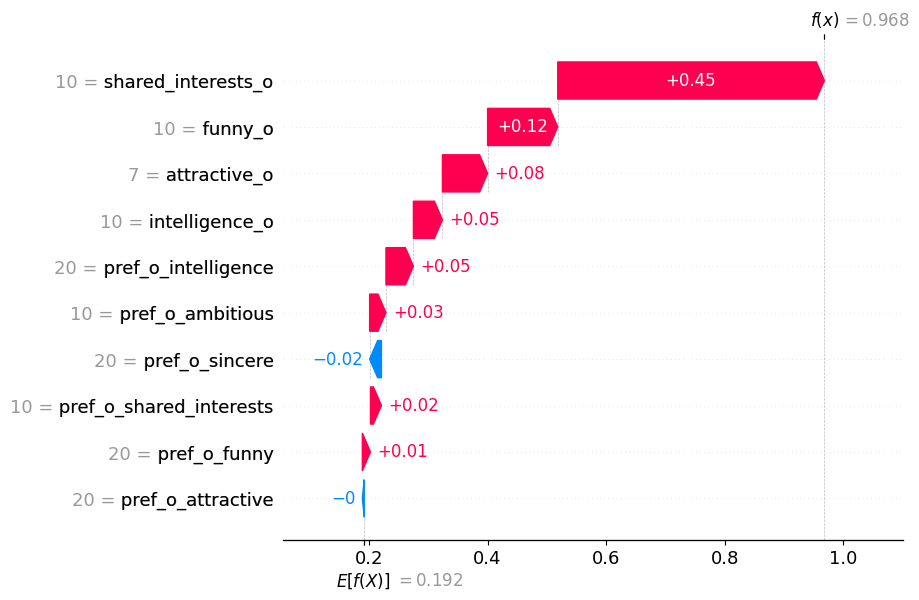

In [200]:
shap_explainer = shap.TreeExplainer(xgb_clf, data=X_train, model_output="probability")
shap_values = shap_explainer(X_test.loc[[max_diff_obs],:]) # shap_values # = shap_values[:, :, 1]

print(f'xgboost, {max_diff_obs=}')
shap.waterfall_plot(shap_values[0])

logistic regression, max_diff_obs=1590


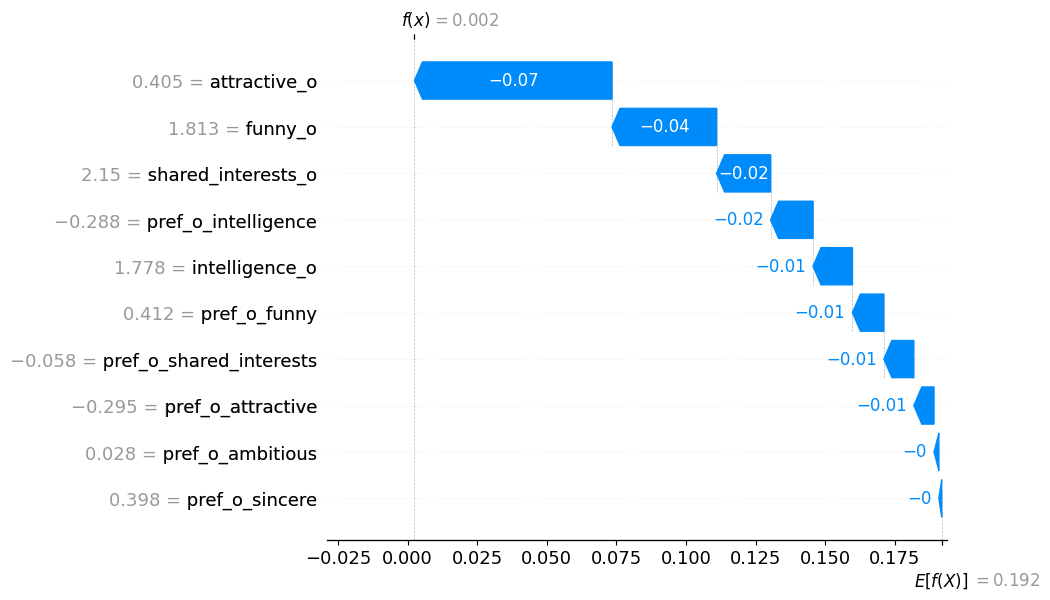

In [202]:
# shap_explainer = shap.TreeExplainer(xgb_clf, data=X_train, model_output="probability")
shap_values = shap_explainer(X_test_scaled.loc[[max_diff_obs],:]) # shap_values # = shap_values[:, :, 1]

print(f'logistic regression, {max_diff_obs=}')
shap.waterfall_plot(shap_values[0])

In [ ]:
# 8. Comment on the results obtained in points (4)-(7)

In [218]:
!cd

C:\Projects\MIMUW\xai\fork\eXplainableMachineLearning-2024\Homeworks\HW4\PiotrGolach


### Random Forest decomposition

In [334]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
import numpy as np


# Lista do przechowywania modeli lasów losowych
random_forests = []
i = SEED
N = 500

clf = RandomForestClassifier(n_estimators=N, bootstrap=True, random_state=i)
clf.fit(X_train, y_train)

RandomForestClassifier(n_estimators=500, random_state=42)

In [335]:
assert len(clf.estimators_) == N

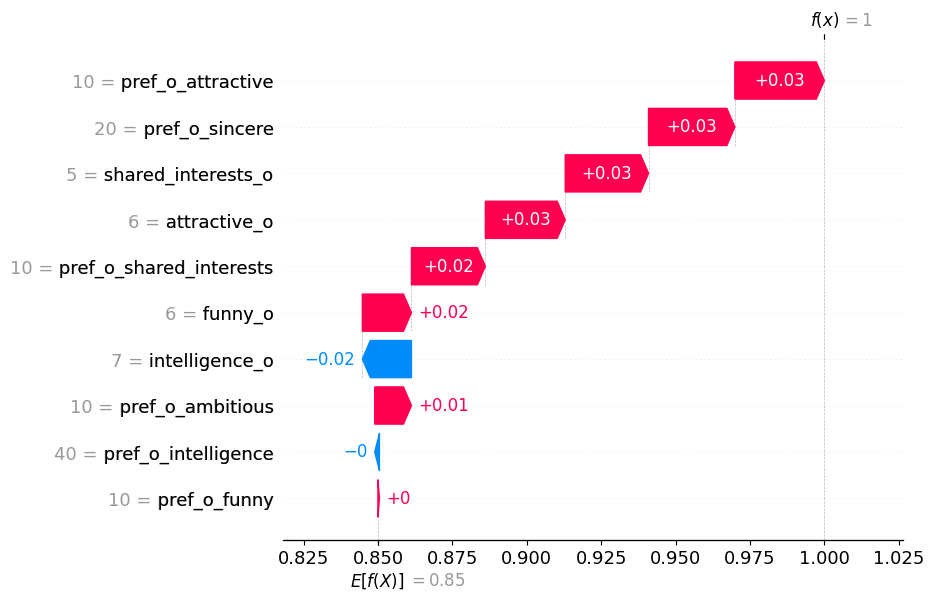

In [336]:
# one estimator
shap_explainer = shap.TreeExplainer(clf.estimators_[0], data=X_train, model_output="probability")
shap_values = shap_explainer(X_test.loc[[obs[0]],:])

shap.waterfall_plot(shap_values[0,:,0])

In [339]:
from tqdm import trange
    
shap_arrays = []
for i in trange(N, desc='Trees from random forest'):
    shap_explainer_clf = shap.TreeExplainer(clf.estimators_[i], data=X_train, model_output="probability")
    shap_values_clf = shap_explainer_clf.shap_values(X_test)[0]
    shap_arrays.append(shap_values_clf)

Trees from random forest: 100%|███████████████████████████████████████████████████████████████████████████████| 500/500 [00:21<00:00, 23.18it/s]


In [448]:
k = X_test.shape[0]
distance_matrix = np.zeros((k, k))

for i in trange(k, desc='Trees from random forest'):
    for j in range(i, k):
        diff = np.abs(shap_arrays[i] - shap_arrays[j]).mean()
        distance_matrix[i,j] = np.sqrt(diff)

Trees from random forest: 100%|██████████████████████████████████████████████████████████████████████████████| 346/346 [00:00<00:00, 457.61it/s]


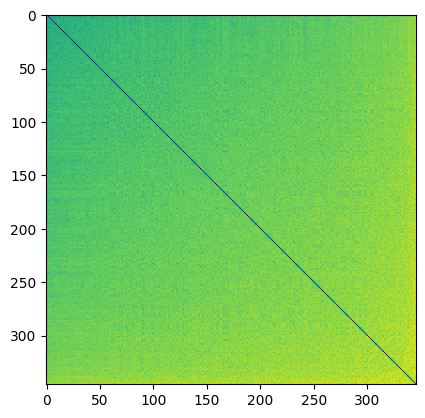

In [449]:
distance_matrix = distance_matrix + distance_matrix.T
distance_matrix.shape

order.shape, distance_matrix.shape, type(distance_matrix)

import matplotlib.pyplot as plt

order = np.argsort(distance_matrix.sum(axis=1))
plt.imshow(distance_matrix[order,:][:,order])
plt.show()

In [ ]:

# shap_df_clf = pd.DataFrame(shap_values_clf, columns=X_test.columns, index=X_test.index)
# shap_df_clf.shape

# shap_values = shap_explainer(X_test)
# shap_values.array.shape

# shap.waterfall_plot(shap_values[0,:,0])

In [249]:
shap_values = explainer.shap_values(X_test)
shap_df = pd.DataFrame(shap_values, columns=X_test.columns, index=X_test.index)

AttributeError: module 'shap' has no attribute 'shape'

In [226]:
shap_values[0]

.values =
array([[ 0.03007143, -0.03007143],
       [ 0.029     , -0.029     ],
       [-0.00157143,  0.00157143],
       [ 0.0005    , -0.0005    ],
       [ 0.01233333, -0.01233333],
       [ 0.02483333, -0.02483333],
       [ 0.02683333, -0.02683333],
       [-0.0165    ,  0.0165    ],
       [ 0.0165    , -0.0165    ],
       [ 0.028     , -0.028     ]])

.base_values =
array([0.85, 0.15])

.data =
array([10., 20., 40., 10., 10., 10.,  6.,  7.,  6.,  5.])

# RF again

In [324]:
from tqdm import trange

N = 500

for i in trange(N):
    clf = RandomForestClassifier(n_estimators=1, bootstrap=True, random_state=i)
    clf.fit(X_train, y_train)
    random_forests.append(clf)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 312.28it/s]


In [325]:
shap_arrays = []
for i in trange(10, desc='Trees from random forest'):
    shap_explainer_clf = shap.TreeExplainer(random_forests[i], data=X_train, model_output="probability")
    shap_values_clf = shap_explainer_clf.shap_values(X_test)[0]
    shap_arrays.append(shap_values_clf)

Trees from random forest: 100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 20.84it/s]


In [329]:
shap_arrays[0] - shap_arrays[1]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [444]:
# !pip install catboost lightgbm

In [455]:
import xgboost as xgb
import lightgbm as lgb
import catboost as cb
import shap
import matplotlib.pyplot as plt

xgb_model = xgb.XGBClassifier()
xgb_model.fit(X_train, y_train)

lgb_model = lgb.LGBMClassifier()
lgb_model.fit(X_train, y_train)

cb_model = cb.CatBoostClassifier(verbose=0)
cb_model.fit(X_train, y_train)

xgb_explainer = shap.TreeExplainer(xgb_model, X_train)
lgb_explainer = shap.TreeExplainer(lgb_model, X_train)
cb_explainer = shap.TreeExplainer(cb_model)

xgb_shap_values = xgb_explainer.shap_values(X_test)
lgb_shap_values = lgb_explainer.shap_values(X_test)
cb_shap_values = cb_explainer.shap_values(X_test)

sample_index = 0  # indeks próbki, dla której chcesz narysować wartości SHAP


[LightGBM] [Info] Number of positive: 121, number of negative: 581
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000068 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 147
[LightGBM] [Info] Number of data points in the train set: 702, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.172365 -> initscore=-1.568960
[LightGBM] [Info] Start training from score -1.568960
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

C:\Users\laptop\anaconda3\envs\pytorch_cpu\lib\site-packages\xgboost\core.py:160: UserWarning:

[00:08:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.



XGBoost SHAP Values


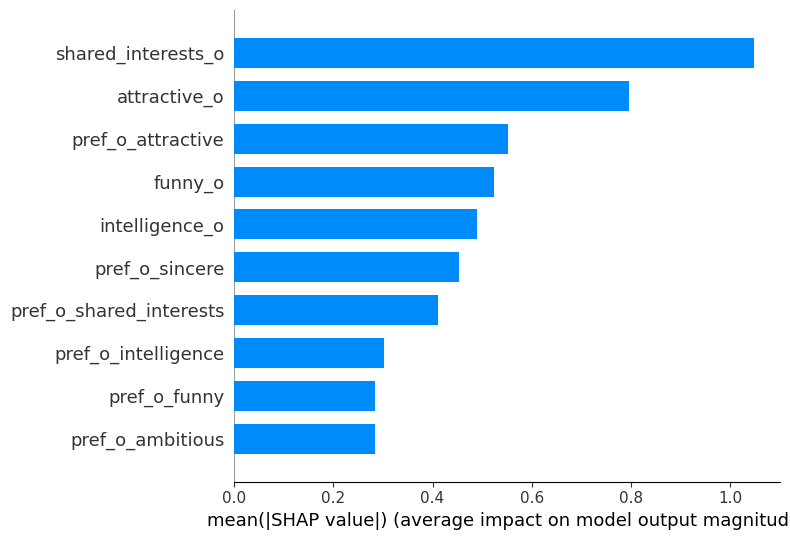

lightGbm SHAP Values


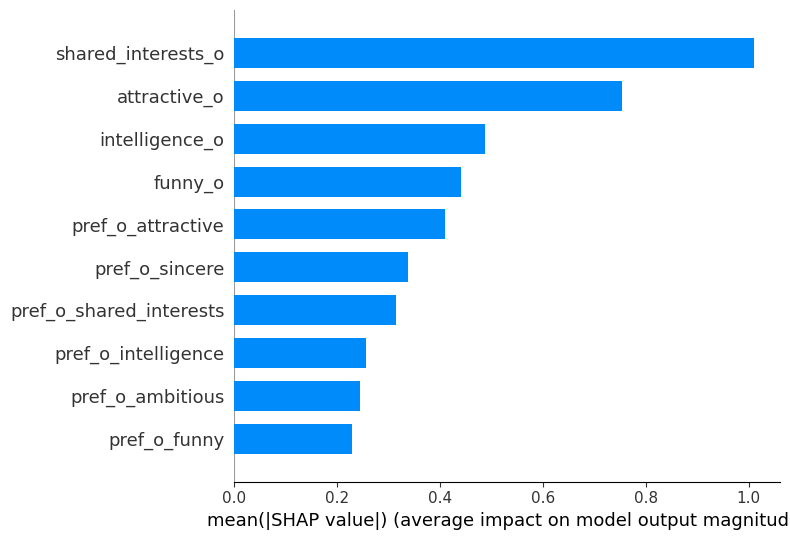

CatBoost SHAP Values


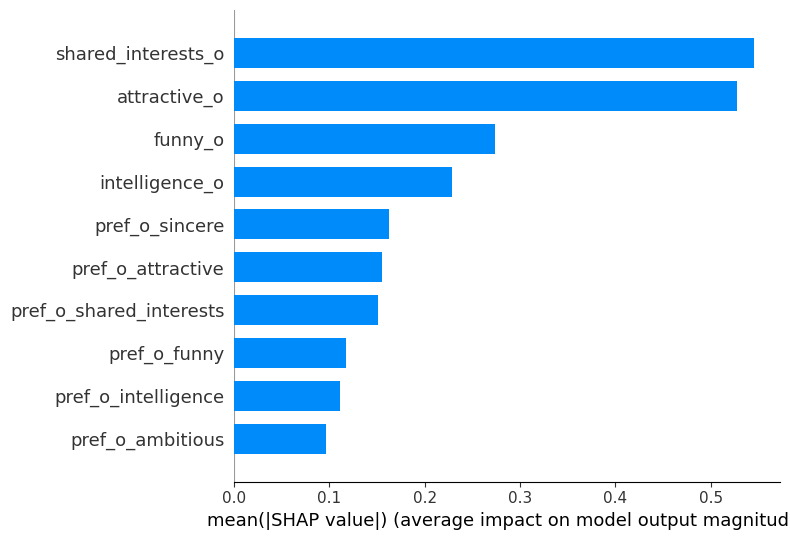

In [464]:
print('XGBoost SHAP Values')
shap.summary_plot(xgb_shap_values, X_test, plot_type='bar')

print('lightGbm SHAP Values')
shap.summary_plot(lgb_shap_values, X_test, plot_type='bar')

print('CatBoost SHAP Values')
shap.summary_plot(cb_shap_values, X_test, plot_type='bar')